### Prolific Data Anaysis 

In [1]:
# Including the necessary imports at the beginning of the analysis script

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

In [2]:
# Load the data from two files
data = pd.read_json('trials.json')


# # Concatenate the two dataframes
data = data[data['trial_type'] == 'main']

# Summarize the dataset
summary_statistics = data.describe()
data.count()

events              12766
trial               12766
current_bonus       12765
trial_type          12766
trial_index         12766
time_elapsed        12766
internal_node_id    12766
wid                 12766
dtype: int64

In [3]:
def calculate_best_reward(graph, rewards, start):
    """
    Calculate the best reward that can be obtained by traversing the graph from the start node.
    """
    def dfs(node, current_reward, include_reward=True):
        if include_reward:
            current_reward += rewards[node]
        if node >= len(graph) or not graph[node]:  # Leaf node
            return current_reward
        return max(dfs(child, current_reward) for child in graph[node])
    return dfs(start, 0, include_reward=False)

def calculate_diffculty( graph, rewards, start):
        """ 
        Calculate the difficulty of the graph based on the average reward obtained by traversing the graph from the start node.
        """
        def dfs(node, current_reward, include_reward=True):
            if include_reward:
                current_reward += rewards[node]
            if node >= len(graph) or not graph[node]:  # Leaf node
                return current_reward, 1  # Return current reward and count this path as 1
            total_reward, total_paths = 0, 0
            for child in graph[node]:
                child_reward, child_paths = dfs(child, current_reward)
                total_reward += child_reward
                total_paths += child_paths
            return total_reward, total_paths

        total_reward, total_paths = dfs(start, 0, include_reward=False)
        best_reward = calculate_best_reward(graph, rewards, start)
        # Difference between the best reward and the average rest reward
        diff = best_reward - ((total_reward - best_reward) / (total_paths-1) )
        return diff


def calculate_diff_2nd(events, rewards, graph):
    """
    Calculate the difference in rewards between the second connected state and the current state 
    for the first 'visit' event that is not the initial state.
    """
    for event in events:
        if event['event'] == 'visit' and not event.get('initial', True):
            current_state = event['state']
            # Check if the current state has connected states in the graph
            if current_state < len(graph) and graph[current_state]:
                # Assuming the graph stores connected states as a list of indices
                if len(graph[current_state]) > 1:  # Make sure there are at least two connected states
                    first_connected_state = graph[current_state][0]
                    second_connected_state = graph[current_state][1]
                    # Check if either connected state index is None or out of range
                    if first_connected_state is None or second_connected_state is None:
                        continue  # Skip to the next event
                    # Check if the indices are within the range of rewards list
                    if first_connected_state >= len(rewards) or second_connected_state >= len(rewards):
                        continue 
                    diff_2 = rewards[second_connected_state] - rewards[current_state]
                    return abs(diff_2)
                
    # Return None if no appropriate 'visit' events or connected states are found
    return 

def calculate_paths(graph, start_node):
    # Recursive function to traverse the binary tree
    def traverse(node, current_path, all_paths):
        if node is None or node >= len(graph) or not graph[node]:
            # Reached a leaf node, add current path to all paths
            all_paths.append(current_path)
            return
        # Visit left and right children
        for child in graph[node]:
            traverse(child, current_path + [child], all_paths)
    
    all_paths = []
    traverse(start_node, [start_node], all_paths)
    return all_paths

def round_up(n):
    try:
        # Convert n to float before rounding
        return round(float(n) * 2) / 2
    except ValueError:
        # Handle the case where conversion to float fails
        return None

def calculate_paths(graph, start_node):
    # Recursive function to traverse the binary tree
    def traverse(node, current_path, all_paths):
        if node is None or node >= len(graph) or not graph[node]:
            # Reached a leaf node, add current path to all paths
            all_paths.append(current_path)
            return
        # Visit children
        for child in graph[node]:
            traverse(child, current_path + [child], all_paths)
    
    all_paths = []
    traverse(start_node, [start_node], all_paths)
    return all_paths

def calculate_reward(paths, rewards):
    path_rewards = []
    for path in paths:
        cumulative_reward = sum(rewards[node] for node in path if rewards[node] is not None)
        path_rewards.append(cumulative_reward)
    return path_rewards


def categorize_path(graph, start, rewards):
        """
        Categorize the paths based on the rewards obtained by traversing the graph from the start node.
        return 1 if the tree has 3 paths
        return 2 if the tree has 4 paths
        return best_second if the best path shares the same immediate child of the start node with the second best path
        return best_min if the best path shares the same immediate child of the start node with the minimum reward path
        return best_third if the best path shares the same immediate child of the start node with the third best path
        return best_alone if the best path does not share the same immediate child of the start node with any other path
        """
        paths = calculate_paths(graph, start)
        path_rewards = calculate_reward(paths, rewards)
        
        # Function to check if two paths share the same immediate child of the start node
        def same_side(start_node, path1, path2):
            if len(path1) > 1 and len(path2) > 1:
                return path1[1] == path2[1]
            return False
        
        if len(path_rewards) == 3:
            max_reward = max(path_rewards)
            max_index = path_rewards.index(max_reward)
            
            remaining_rewards = [r for r in path_rewards if r != max_reward]
            second_best_reward = max(remaining_rewards)
            second_best_index = path_rewards.index(second_best_reward)
            
            min_reward = min(path_rewards)
            min_index = path_rewards.index(min_reward)
            
            if same_side(start, paths[max_index], paths[second_best_index]):
                return (1, "best_second")
            elif same_side(start, paths[max_index], paths[min_index]):
                return (1, "best_min")
            else:
                return (1, "best_alone")
        
        elif len(path_rewards) == 4:
            max_reward = max(path_rewards)
            max_index = path_rewards.index(max_reward)
            
            remaining_rewards = [r for r in path_rewards if r != max_reward]
            second_best_reward = max(remaining_rewards)
            second_best_index = path_rewards.index(second_best_reward)
            
            third_best_reward = sorted(remaining_rewards)[-2]
            third_best_index = path_rewards.index(third_best_reward)
            
            min_reward = min(path_rewards)
            min_index = path_rewards.index(min_reward)
            
            if same_side(start, paths[max_index], paths[second_best_index]):
                return (2, "best_second")
            elif same_side(start, paths[max_index], paths[min_index]):
                return (2, "best_min")
    #         elif same_side(start, paths[max_index], paths[third_best_index]):
    #             return (2, "best_third")
            else:
                return (2, "best_third")

        return (None, "undefined")


def accuracy_first(events, graph, rewards, start):
    # Calculate all possible paths from the start node
    all_paths = calculate_paths(graph, start)
    # Calculate rewards for each path
    path_rewards = calculate_reward(all_paths, rewards)
    # Find the best path based on the maximum reward
    best_path_index = path_rewards.index(max(path_rewards))
    best_path = all_paths[best_path_index]

    # Collect all visited states from the events
    visited_nodes = [event['state'] for event in events if 'state' in event]

    # Compare the first node visited beyond the start node to the first node in the best reward path
    # Ensure there are enough nodes in visited_nodes and best_path to perform this comparison
    if len(visited_nodes) > 1 and len(best_path) > 1:
        # Check if the first node visited (beyond start) matches the first node of the best path (beyond start)
        accuracy = 1 if visited_nodes[1] == best_path[1] else 0
    else:
        accuracy = 0

    return accuracy



In [4]:
processed_trials = []

for index, row in data.iterrows():
    trial = row['trial']
    events = row['events']
    graph = trial['graph']
    rewards = trial['rewards']
    start = trial['start']
    
    best_reward = calculate_best_reward(graph, rewards, start)
    df, trial_type = categorize_path(graph, start, rewards)
    difficulty = calculate_diffculty(graph, rewards, start)

   
    max_reward = best_reward  # You've already calculated this, no need to do it again
    visited_nodes = set(event['state'] for event in events if 'state' in event)
    current_reward = sum(rewards[node] for node in visited_nodes if rewards[node] is not None)
    diff_2 = calculate_diff_2nd(events, rewards, graph)
    
    accuracy = 1 if current_reward == max_reward else 0
    accuracy_1 = accuracy_first(events, graph, rewards, start)
    # accuracy = current_reward / max_reward if max_reward > 0 else 0
    wid = row['wid']
    visit_times = [event['time'] for event in events if event['event'] == 'visit']
    RT_first, RT_second = None, None  # Initialize to handle cases where there are not exactly 3 visit times
    if len(visit_times) >= 3:  # Ensure there are at least 3 times recorded
        RT_first = visit_times[1] - visit_times[0]
        RT_second = visit_times[2] - visit_times[1]
        RT = visit_times[2] - visit_times[0]
    
    # You've already assigned 'wid' above, no need to do it again
    
    processed_trials.append({
        'graph':graph,
        'reward':rewards,
        'trialNumber': trial['trialNumber'],
        'difficulty': difficulty,
        "difficulty_2":diff_2,
        "type": trial_type,
        'wid': wid,
        'RT_first_visit': RT_first,
        'RT_second_visit': RT_second,
        'RT': RT,
        'max_reward': max_reward,
        'current_reward': current_reward,
        'loss':max_reward - current_reward,
        'accuracy': accuracy,
        'accuracy_1': accuracy_1,
        'df': df
    })
     
processed_df = pd.DataFrame(processed_trials)

In [5]:
#Exclusion criteria
filtered_df = processed_df.groupby('wid')['accuracy'].mean().reset_index()
filtered_df = filtered_df[filtered_df['accuracy'] > 0.5]
processed_df = processed_df[processed_df['wid'].isin(filtered_df['wid'])]
# processed_df = processed_df[processed_df['RT_first_visit'] > 200]
processed_df = processed_df[processed_df['RT'] <  10000]
# processed_df = processed_df[processed_df['RT_second_visit'] > 100]

# Filter the DataFrame diffculty values between 1 and 11, covert to int and remove non-integer values
processed_df['difficulty'] = pd.to_numeric(processed_df['difficulty'], errors='coerce')
processed_df = processed_df[(processed_df['difficulty'] > 1) & (processed_df['difficulty'] <= 11)]
# processed_df = processed_df[pd.to_numeric(processed_df['difficulty'], errors='coerce').apply(lambda x: x.is_integer() if pd.notna(x) else False)]

# Convert 'difficulty' to int now that we've filtered out non-integer values
processed_df['difficulty'] = processed_df['difficulty'].astype(int)
# Create df1 with 5 nodes tree(3 paths)
df1 = processed_df[processed_df['df'] == 1]
# Create df2 with 6 nodes tree(4 paths)
df2 = processed_df[processed_df['df'] == 2]
processed_df.count()

graph              11179
reward             11179
trialNumber        11179
difficulty         11179
difficulty_2        8069
type               11179
wid                11179
RT_first_visit     11178
RT_second_visit    11178
RT                 11179
max_reward         11179
current_reward     11179
loss               11179
accuracy           11179
accuracy_1         11179
df                 11179
dtype: int64

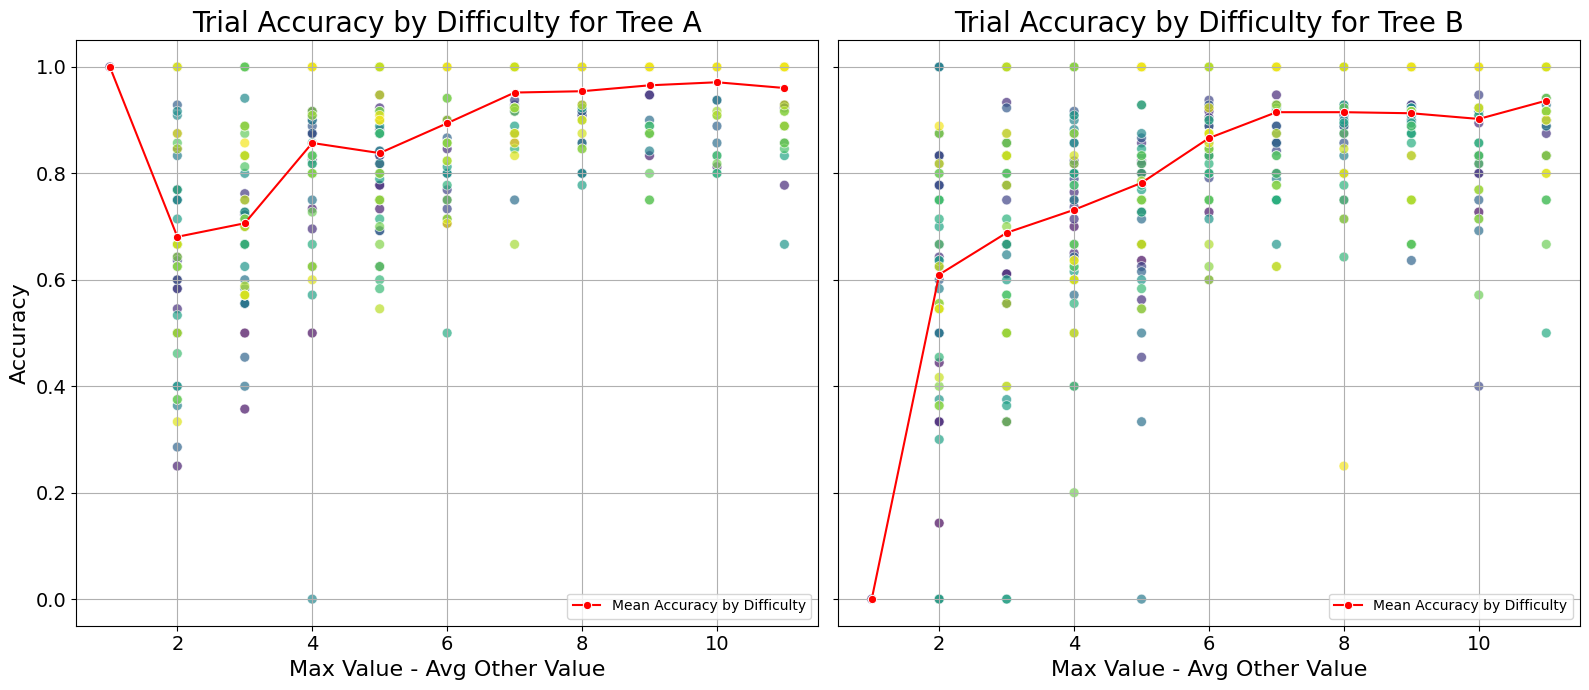

In [6]:
df1 = pd.DataFrame(df1)  # Replace with actual DataFrame creation/population for df1
df2 = pd.DataFrame(df2)  # Replace with actual DataFrame creation/population for df2

# Create subplots with a slightly smaller figsize
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)  # Adjusted from (18, 8) to (16, 7)

# Function to plot data
def plot_data(df, ax, title):
    # Group by difficulty to calculate mean accuracy for the line plot
    mean_accuracy_by_difficulty = df.groupby('difficulty')['accuracy'].mean().reset_index()

    # Plot mean accuracy by difficulty with a line plot
    sns.lineplot(data=mean_accuracy_by_difficulty, x='difficulty', y='accuracy', ax=ax, marker='o', color='red', label='Mean Accuracy by Difficulty')

    # Group by participant AND difficulty to calculate mean accuracy for the scatter plot
    mean_accuracy_by_participant_and_difficulty = df.groupby(['wid', 'difficulty'])['accuracy'].mean().reset_index()

    # Plot individual mean accuracies by participant for each difficulty
    sns.scatterplot(data=mean_accuracy_by_participant_and_difficulty, x='difficulty', y='accuracy', hue='wid', ax=ax, palette='viridis', legend=None, s=50, alpha=0.7)

    # Setting titles and labels with larger font size
    ax.set_title(title, fontsize=20)  # Increased fontsize for title
    ax.set_xlabel('Max Value - Avg Other Value', fontsize=16)  # Increased fontsize for xlabel
    ax.set_ylabel('Accuracy', fontsize=16)  # Increased fontsize for ylabel
    
    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increased labelsize for tick parameters
    
    ax.grid(True)

# Plotting for df1
plot_data(df1, axes[0], 'Trial Accuracy by Difficulty for Tree A')

# Plotting for df2
plot_data(df2, axes[1], 'Trial Accuracy by Difficulty for Tree B')

plt.tight_layout()
plt.show()

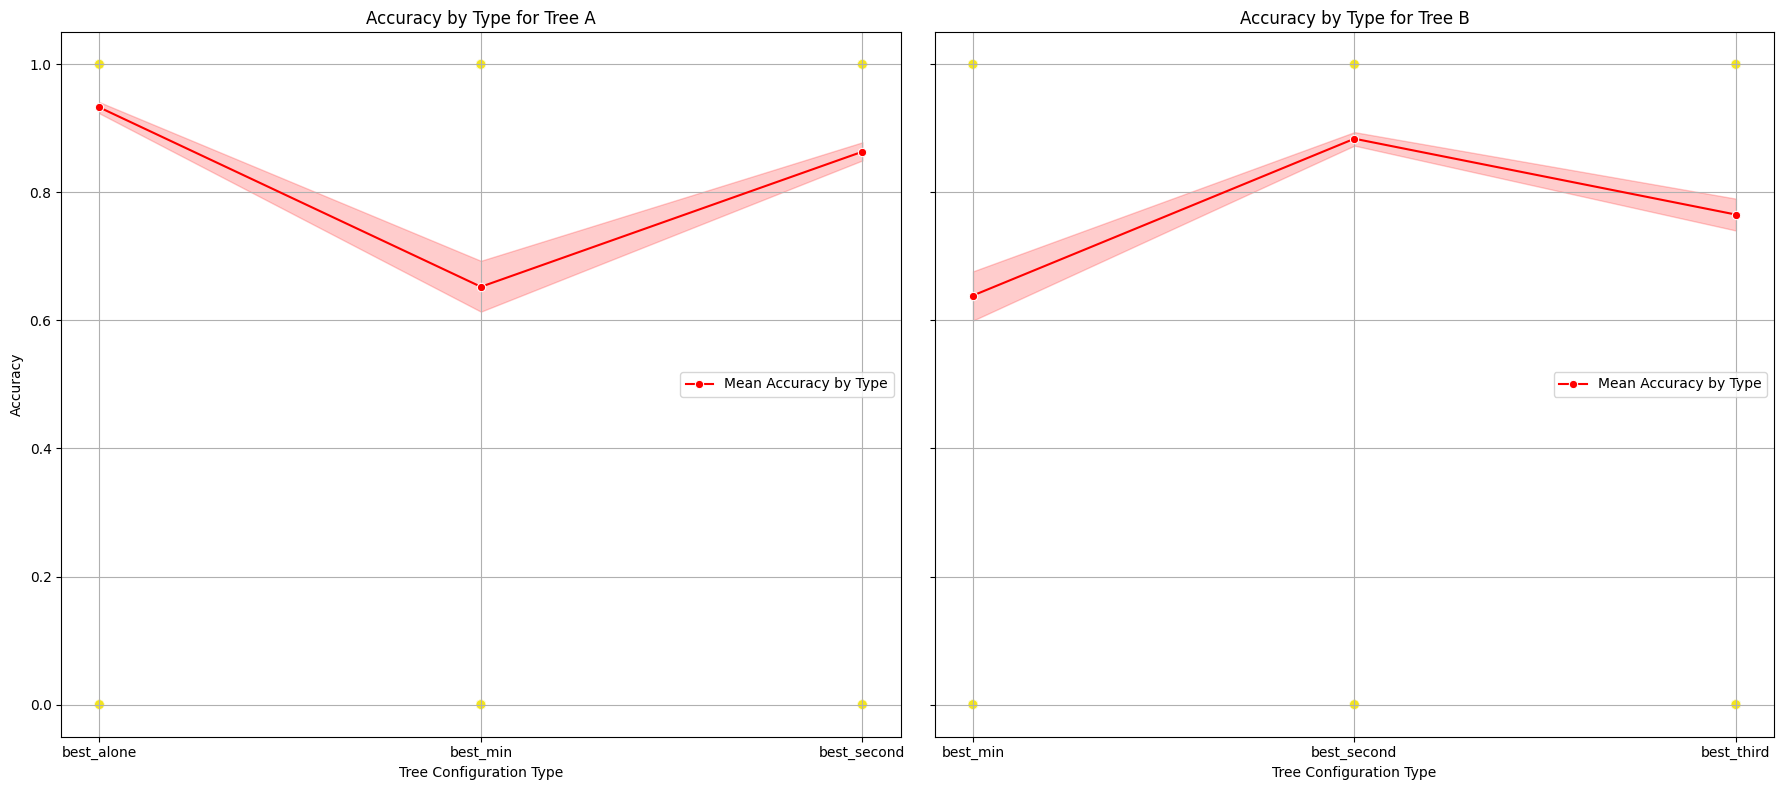

In [7]:
# Set 'type' column in both DataFrames to category type with the manual order
df1['type'] = pd.Categorical(df1['type'])
df2['type'] = pd.Categorical(df2['type'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

def plot_data(df, ax, title):
    # Since 'type' is already an ordered categorical, Seaborn will use this order automatically
    sns.lineplot(data=df, x='type', y='accuracy', ax=ax, marker='o', color='red', label='Mean Accuracy by Type')
    sns.scatterplot(data=df, x='type', y='accuracy', hue='wid', ax=ax, palette='viridis', legend=None, s=50, alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel('Tree Configuration Type')
    ax.set_ylabel('Accuracy')
    ax.grid(True)



# Plotting for df1 and df2
plot_data(df1, axes[0], 'Accuracy by Type for Tree A')
plot_data(df2, axes[1], 'Accuracy by Type for Tree B')

plt.tight_layout()
plt.show()

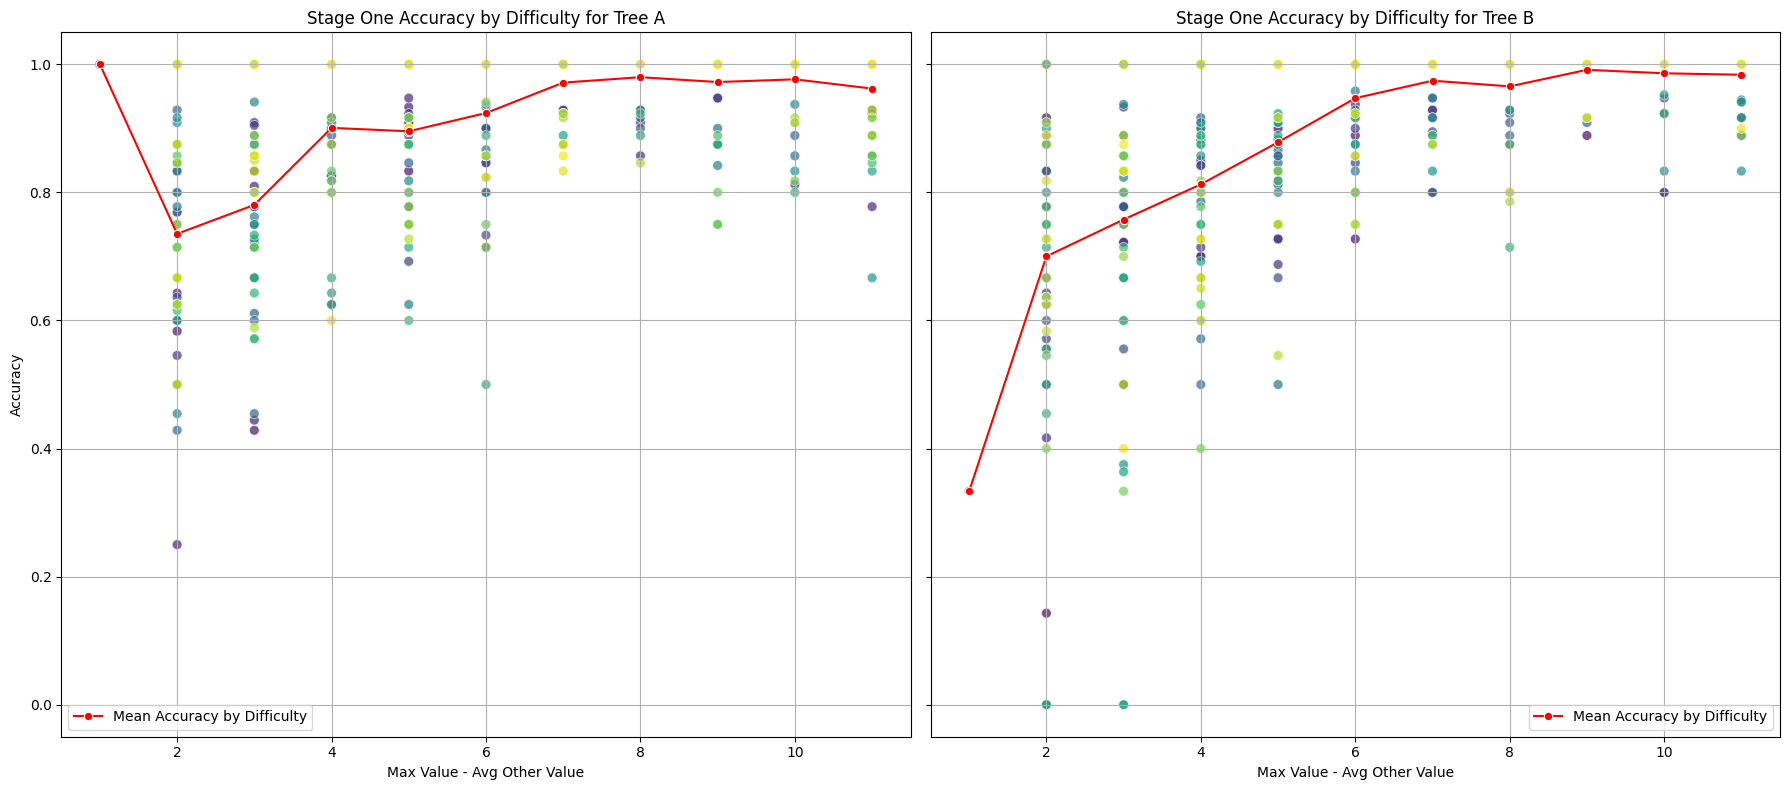

In [8]:
df1 = pd.DataFrame(df1)  # Replace with actual DataFrame creation/population for df1
df2 = pd.DataFrame(df2)  # Replace with actual DataFrame creation/population for df2

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Function to plot data
def plot_data(df, ax, title):
    # Group by difficulty to calculate mean accuracy for the line plot
    mean_accuracy_by_difficulty = df.groupby('difficulty')['accuracy_1'].mean().reset_index()

    # Plot mean accuracy by difficulty with a line plot
    sns.lineplot(data=mean_accuracy_by_difficulty, x='difficulty', y='accuracy_1', ax=ax, marker='o', color='red', label='Mean Accuracy by Difficulty')

    # Group by participant AND difficulty to calculate mean accuracy for the scatter plot
    mean_accuracy_by_participant_and_difficulty = df.groupby(['wid', 'difficulty'])['accuracy_1'].mean().reset_index()

    # Plot individual mean accuracies by participant for each difficulty
    sns.scatterplot(data=mean_accuracy_by_participant_and_difficulty, x='difficulty', y='accuracy_1', hue='wid', ax=ax, palette='viridis', legend=None, s=50, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('Max Value - Avg Other Value')
    ax.set_ylabel('Accuracy')
    ax.grid(True)

# Plotting for df1
plot_data(df1, axes[0], 'Stage One Accuracy by Difficulty for Tree A')

# Plotting for df2
plot_data(df2, axes[1], 'Stage One Accuracy by Difficulty for Tree B')

plt.tight_layout()
plt.show()

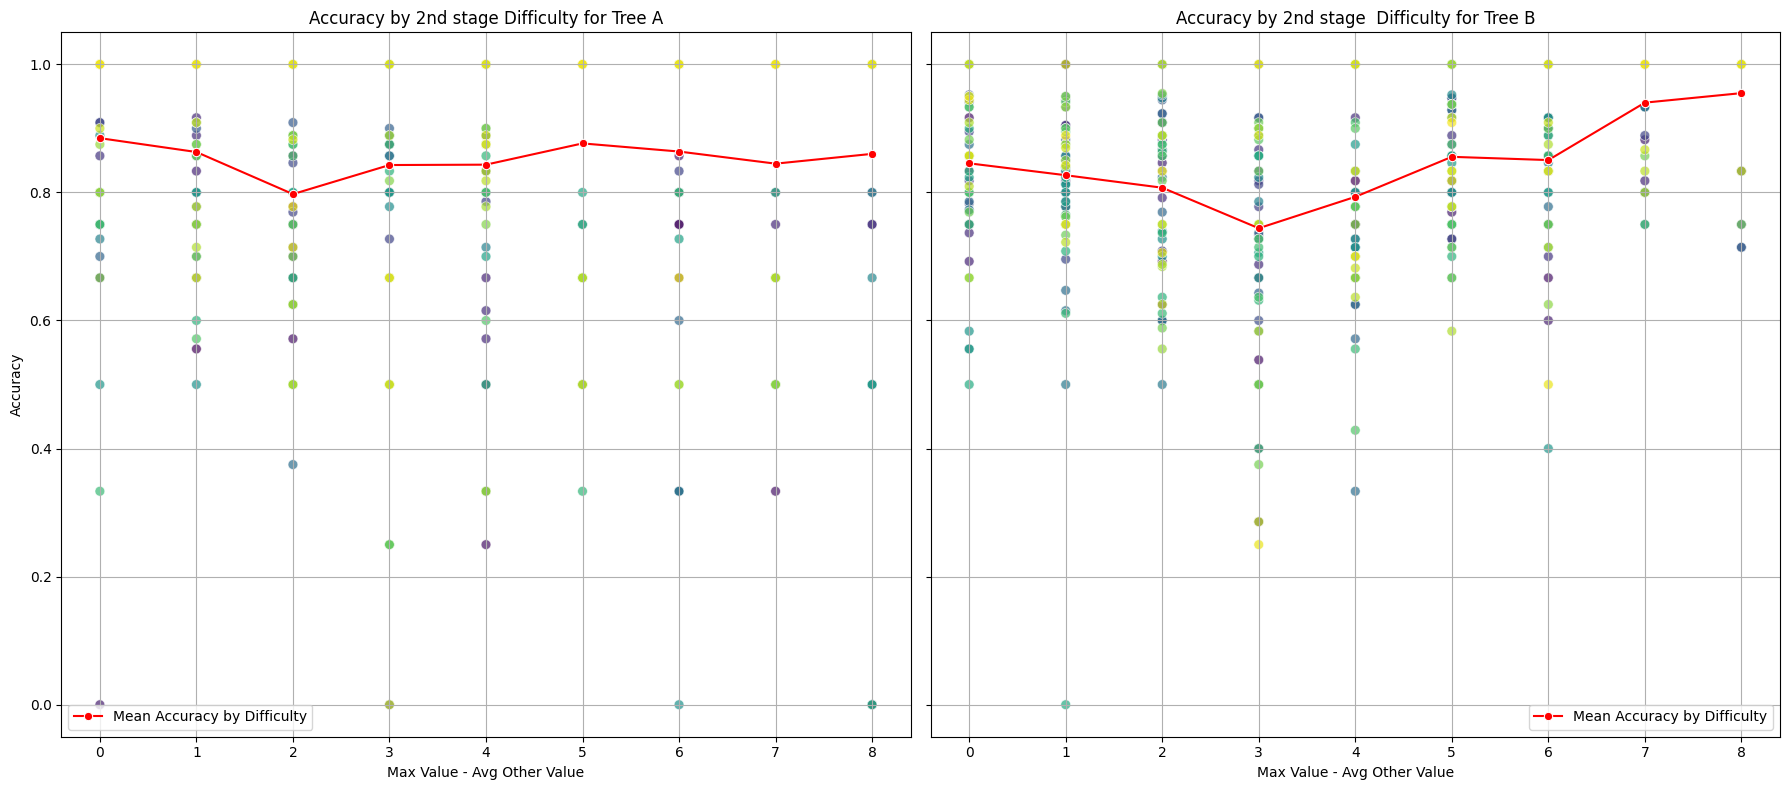

In [9]:
df1 = pd.DataFrame(df1)  # Replace with actual DataFrame creation/population for df1
df2 = pd.DataFrame(df2)  # Replace with actual DataFrame creation/population for df2

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Function to plot data
def plot_data(df, ax, title):
    # Group by difficulty to calculate mean accuracy for the line plot
    mean_accuracy_by_difficulty = df.groupby('difficulty_2')['accuracy'].mean().reset_index()

    # Plot mean accuracy by difficulty with a line plot
    sns.lineplot(data=mean_accuracy_by_difficulty, x='difficulty_2', y='accuracy', ax=ax, marker='o', color='red', label='Mean Accuracy by Difficulty')

    # Group by participant AND difficulty to calculate mean accuracy for the scatter plot
    mean_accuracy_by_participant_and_difficulty = df.groupby(['wid', 'difficulty_2'])['accuracy'].mean().reset_index()

    # Plot individual mean accuracies by participant for each difficulty
    sns.scatterplot(data=mean_accuracy_by_participant_and_difficulty, x='difficulty_2', y='accuracy', hue='wid', ax=ax, palette='viridis', legend=None, s=50, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('Max Value - Avg Other Value')
    ax.set_ylabel('Accuracy')
    ax.grid(True)


df1_2 = df1[df1['accuracy_1'] == 1]
df2_2 = df2[df2['accuracy_1'] == 1]
# Plotting for df1
plot_data(df1, axes[0], 'Accuracy by 2nd stage Difficulty for Tree A')

# Plotting for df2
plot_data(df2, axes[1], 'Accuracy by 2nd stage  Difficulty for Tree B')

plt.tight_layout()
plt.show()

/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/4185494807.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df1_RT_long, x='difficulty', y='Reaction Time', hue='Visit', marker='o', ci='sd',


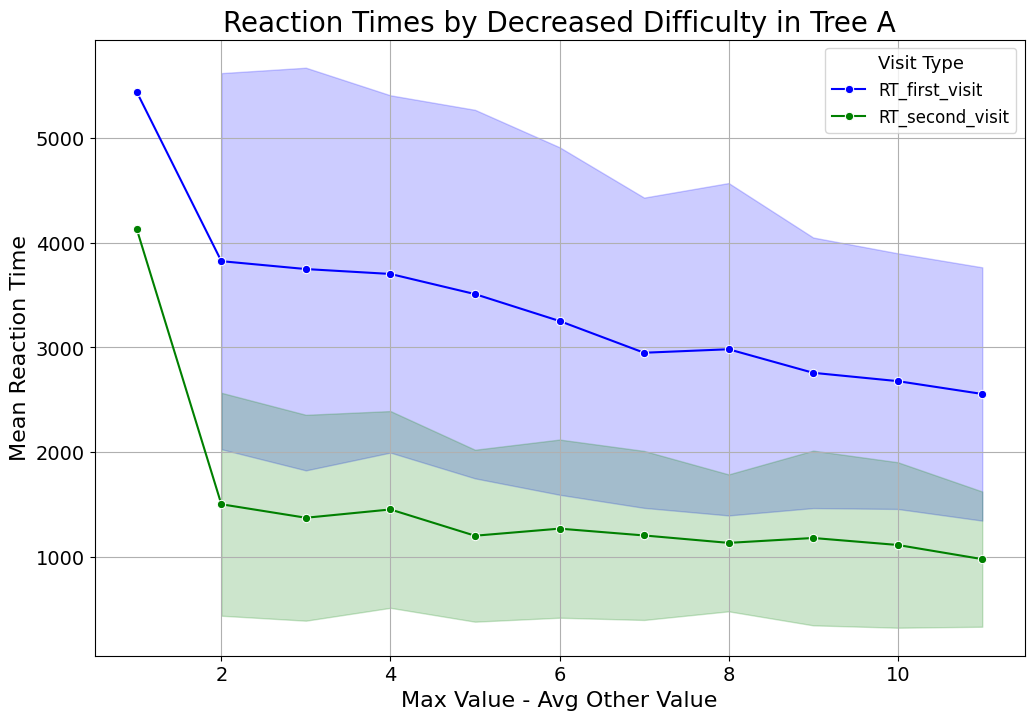

In [10]:
# Assuming df1 is your DataFrame and it includes 'accuracy', 'difficulty', 'RT_first_visit', and 'RT_second_visit' columns
df1_RT = df1[df1['accuracy'] == 1]

# Create a long format DataFrame for easier plotting with Seaborn
df1_RT_long = pd.melt(df1_RT, id_vars=['difficulty'], value_vars=['RT_first_visit', 'RT_second_visit'],
                      var_name='Visit', value_name='Reaction Time')

# Now plotting using Seaborn with standard deviation for error bars
plt.figure(figsize=(12, 8))
sns.lineplot(data=df1_RT_long, x='difficulty', y='Reaction Time', hue='Visit', marker='o', ci='sd', 
             palette=['blue', 'green'])

# Setting font sizes
plt.title('Reaction Times by Decreased Difficulty in Tree A', fontsize=20)
plt.xlabel('Max Value - Avg Other Value', fontsize=16)
plt.ylabel('Mean Reaction Time', fontsize=16)
plt.xticks(fontsize=14)  # Font size for x-axis tick labels
plt.yticks(fontsize=14)  # Font size for y-axis tick labels
plt.legend(title='Visit Type', title_fontsize='13', fontsize='12')  # Adjust legend title and item font sizes
plt.grid(True)
plt.show()

/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/2800595830.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df1_RT_long, x='type', y='Reaction Time', hue='Visit', marker='o', ci='sd',


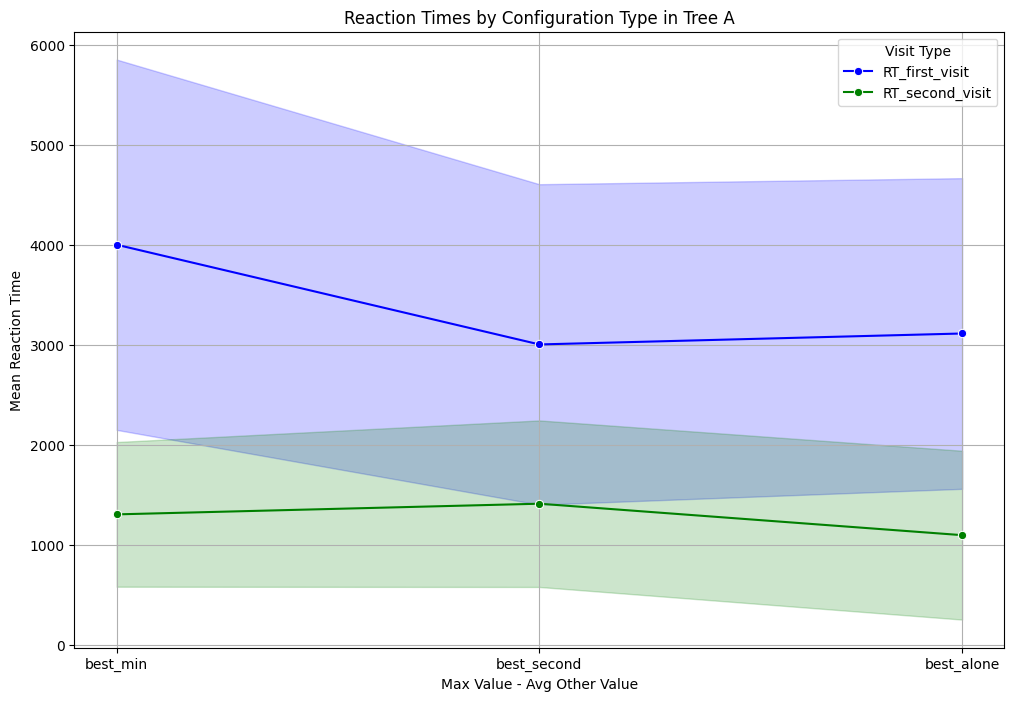

In [11]:
manual_order =  ['best_min', 'best_second', 'best_alone'] # Replace these with your actual categories

# Assuming df1 is already loaded and contains the relevant columns
df1['type'] = pd.Categorical(df1['type'], categories=manual_order, ordered=True)

df1_RT = df1[df1['accuracy'] == 1]

# Create a long format DataFrame for easier plotting with Seaborn
df1_RT_long = pd.melt(df1_RT, id_vars=['type'], value_vars=['RT_first_visit', 'RT_second_visit'],
                      var_name='Visit', value_name='Reaction Time')

# Now plotting using Seaborn with standard deviation for error bars
plt.figure(figsize=(12, 8))
sns.lineplot(data=df1_RT_long, x='type', y='Reaction Time', hue='Visit', marker='o', ci='sd', 
             palette=['blue', 'green'])

plt.title('Reaction Times by Configuration Type in Tree A')
plt.xlabel('Max Value - Avg Other Value')
plt.ylabel('Mean Reaction Time')
plt.legend(title='Visit Type')
plt.grid(True)
plt.show()

/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/4239416991.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df2_RT_long, x='difficulty', y='Reaction Time', hue='Visit', marker='o', ci='sd',


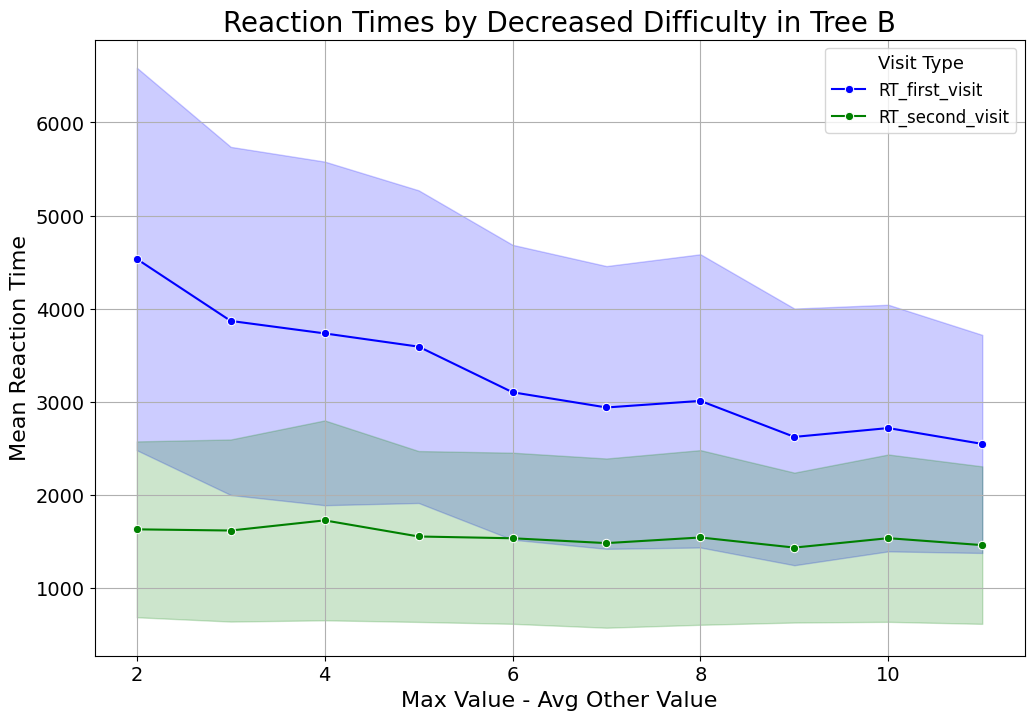

In [12]:
# Assuming df1 is your DataFrame and it includes 'accuracy', 'difficulty', 'RT_first_visit', and 'RT_second_visit' columns
df2_RT = df2[df2['accuracy'] == 1]

# Create a long format DataFrame for easier plotting with Seaborn
df2_RT_long = pd.melt(df2_RT, id_vars=['difficulty'], value_vars=['RT_first_visit', 'RT_second_visit'],
                      var_name='Visit', value_name='Reaction Time')

# Now plotting using Seaborn with standard deviation for error bars
plt.figure(figsize=(12, 8))
sns.lineplot(data=df2_RT_long, x='difficulty', y='Reaction Time', hue='Visit', marker='o', ci='sd', 
             palette=['blue', 'green'])

# Setting font sizes
plt.title('Reaction Times by Decreased Difficulty in Tree B', fontsize=20)
plt.xlabel('Max Value - Avg Other Value', fontsize=16)
plt.ylabel('Mean Reaction Time', fontsize=16)
plt.xticks(fontsize=14)  # Font size for x-axis tick labels
plt.yticks(fontsize=14)  # Font size for y-axis tick labels
plt.legend(title='Visit Type', title_fontsize='13', fontsize='12')  # Adjust legend title and item font sizes
plt.grid(True)
plt.show()

/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/1358006300.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df2_RT_long, x='type', y='Reaction Time', hue='Visit', marker='o', ci='sd',


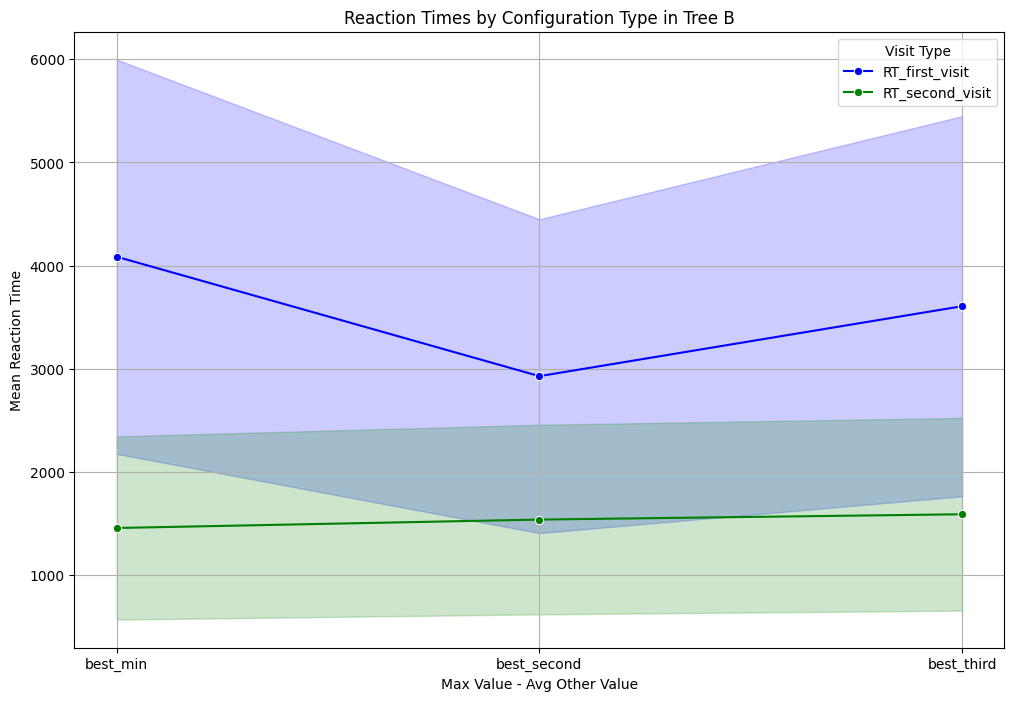

In [13]:
manual_order =  ['best_min', 'best_second', 'best_third'] # Replace these with your actual categories

# Assuming df1 is already loaded and contains the relevant columns
df2['type'] = pd.Categorical(df2['type'], categories=manual_order, ordered=True)

df2_RT = df2[df2['accuracy'] == 1]

# Create a long format DataFrame for easier plotting with Seaborn
df2_RT_long = pd.melt(df2_RT, id_vars=['type'], value_vars=['RT_first_visit', 'RT_second_visit'],
                      var_name='Visit', value_name='Reaction Time')

# Now plotting using Seaborn with standard deviation for error bars
plt.figure(figsize=(12, 8))
sns.lineplot(data=df2_RT_long, x='type', y='Reaction Time', hue='Visit', marker='o', ci='sd', 
             palette=['blue', 'green'])

plt.title('Reaction Times by Configuration Type in Tree B')
plt.xlabel('Max Value - Avg Other Value')
plt.ylabel('Mean Reaction Time')
plt.legend(title='Visit Type')
plt.grid(True)
plt.show()

/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/3048893492.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,


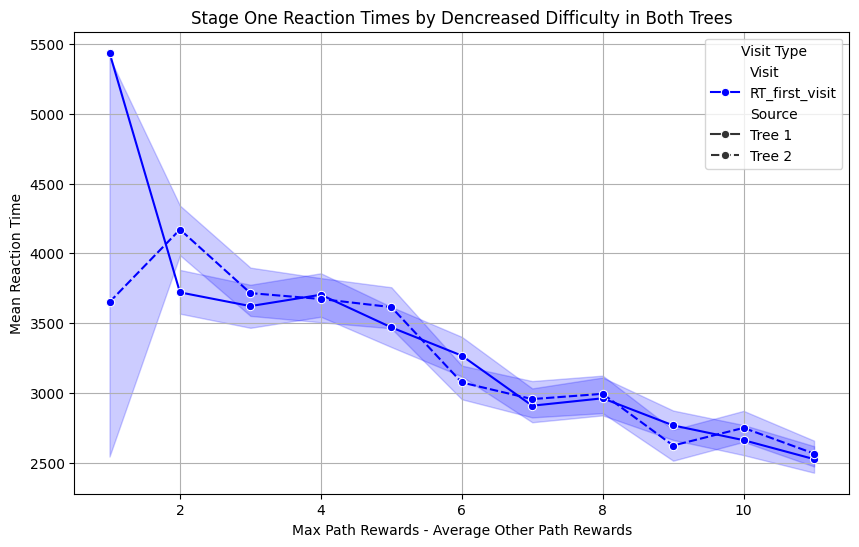

In [14]:
# Assuming df1 and df2 have been properly defined and have the necessary columns
df1['Source'] = 'Tree 1'
df2['Source'] = 'Tree 2'
combined_df = pd.concat([df1, df2])
# combined_df = combined_df[combined_df['accuracy'] == 1]
# Create a figure and axes for plotting
plt.figure(figsize=(10, 6))  # Define the figure size
df_RT_long = pd.melt(combined_df, id_vars=['difficulty', 'Source'], value_vars=['RT_first_visit'],
                     var_name='Visit', value_name='Reaction Time')


sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,
             palette=['blue'])  


# Set plot title and labels
plt.title('Stage One Reaction Times by Dencreased Difficulty in Both Trees')
plt.xlabel('Max Path Rewards - Average Other Path Rewards')
plt.ylabel('Mean Reaction Time')

# Adding a legend
plt.legend(title='Visit Type')

# Adding grid
plt.grid(True)

# Display the plot
plt.show()


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/3373332946.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_RT_long, x='difficulty_2', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,


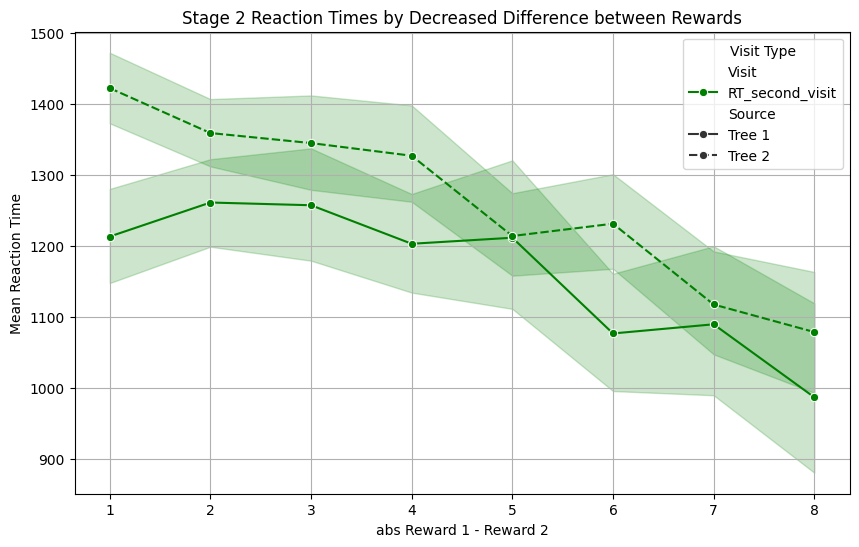

In [15]:
# Assuming df1 and df2 have been properly defined and have the necessary columns
df1['Source'] = 'Tree 1'
df2['Source'] = 'Tree 2'
combined_df = pd.concat([df1, df2])
combined_df = combined_df[combined_df['RT_second_visit'] < combined_df['RT_first_visit']]
# combined_df = combined_df[combined_df['accuracy'] == 1]
combined_df = combined_df[combined_df['difficulty_2'] >=1]
# Create a figure and axes for plotting
plt.figure(figsize=(10, 6))  # Define the figure size
df_RT_long = pd.melt(combined_df, id_vars=['difficulty_2', 'Source'], value_vars=['RT_second_visit'],
                     var_name='Visit', value_name='Reaction Time')

sns.lineplot(data=df_RT_long, x='difficulty_2', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,
             palette=['green'])  

# Set plot title and labels
plt.title('Stage 2 Reaction Times by Decreased Difference between Rewards')
plt.xlabel('abs Reward 1 - Reward 2')
plt.ylabel('Mean Reaction Time')

# Adding a legend
plt.legend(title='Visit Type')

# Adding grid
plt.grid(True)

# Display the plot
plt.show()


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/9471163.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,


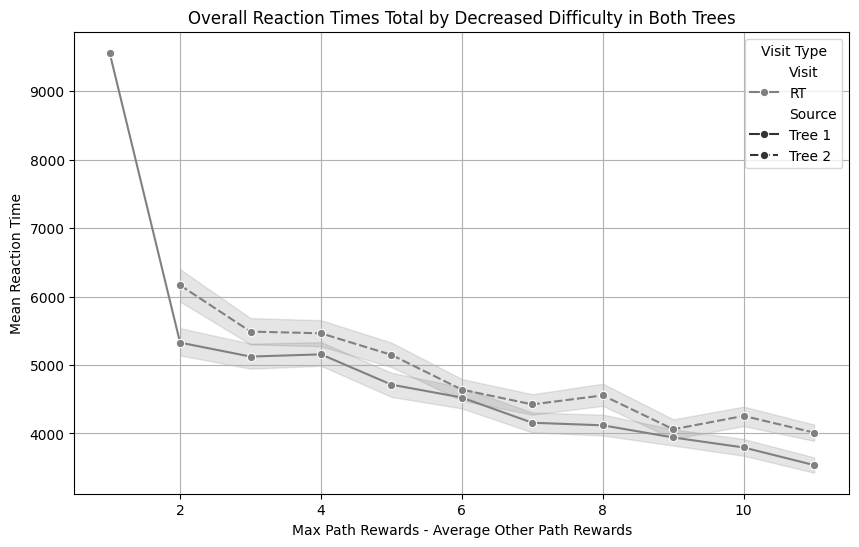

In [16]:
# Assuming df1 and df2 have been properly defined and have the necessary columns
df1['Source'] = 'Tree 1'
df2['Source'] = 'Tree 2'
combined_df = pd.concat([df1, df2])

# Filtering only entries with accuracy == 1 (uncomment if needed)
combined_df = combined_df[combined_df['accuracy'] == 1]

# Melt the DataFrame for plotting
df_RT_long = pd.melt(combined_df, id_vars=['difficulty', 'Source'], value_vars=['RT'],
                     var_name='Visit', value_name='Reaction Time')

# Create a figure and axes for plotting
plt.figure(figsize=(10, 6))

# Plot using Seaborn
sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', marker='o', ci=95,
             palette=['grey'])  

# Set plot title and labels
plt.title('Overall Reaction Times Total by Decreased Difficulty in Both Trees')
plt.xlabel('Max Path Rewards - Average Other Path Rewards')
plt.ylabel('Mean Reaction Time')

# Adding a legend
plt.legend(title='Visit Type')

# Adding grid
plt.grid(True)

# Display the plot
plt.show()


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31360/1122778641.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', markers=True, ci=95)


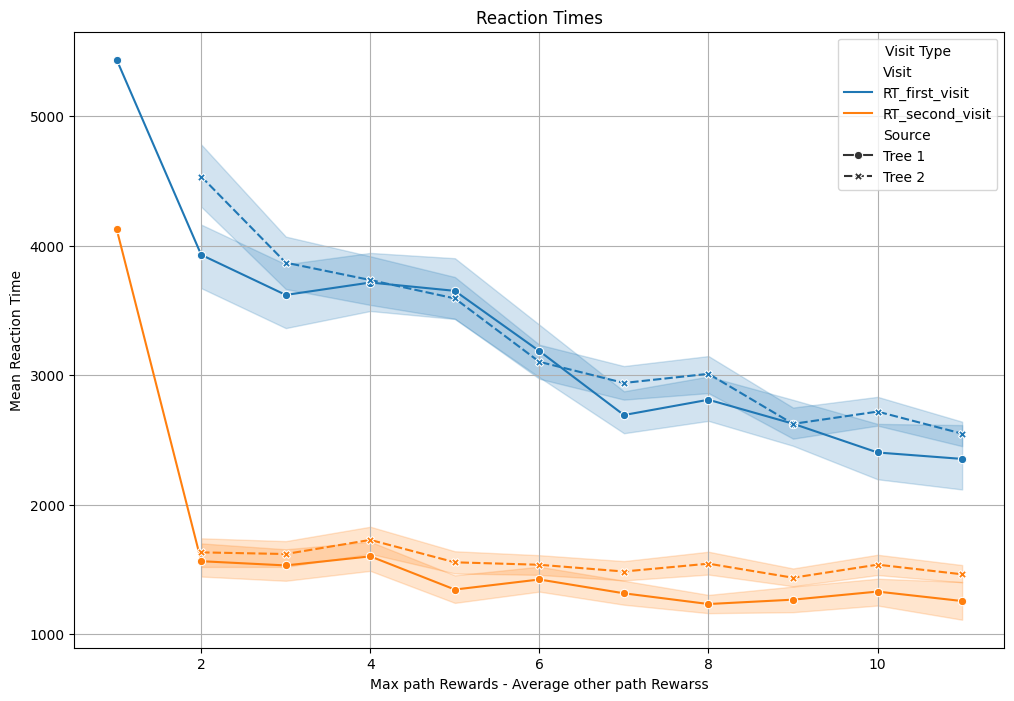

In [17]:

# Assuming df1 and df2 have been properly defined and have the necessary columns
df1['Source'] = 'Tree 1'
df2['Source'] = 'Tree 2'

# Combine the dataframes
combined_df = pd.concat([df1, df2])

# Filter out rows where 'difficulty_2' is None and accuracy is 1
combined_df = combined_df[combined_df['difficulty_2'].notna() & (combined_df['accuracy'] == 1)]

# Melt the DataFrame to prepare for plotting
df_RT_long = pd.melt(combined_df, id_vars=['difficulty', 'Source'], value_vars=['RT_first_visit', 'RT_second_visit'],
                     var_name='Visit', value_name='Reaction Time')

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Plot using seaborn
sns.lineplot(data=df_RT_long, x='difficulty', y='Reaction Time', hue='Visit', style='Source', markers=True, ci=95)

# Set plot title and labels
plt.title('Reaction Times')
plt.xlabel('Max path Rewards - Average other path Rewarss')
plt.ylabel('Mean Reaction Time')

# Adding a legend
plt.legend(title='Visit Type')

# Adding grid
plt.grid(True)

# Display the plot
plt.show()
